In [99]:
import sys, os
import tqdm
import numpy as np
import seaborn as sns
import torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
from torchvision import transforms
from IPython.display import Image as showImg
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Subset
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt
from copy import deepcopy
import matplotlib
import pandas as pd
from sklearn_extra.cluster import KMedoids

###
if '../' not in sys.path:
    sys.path = ['../'] + sys.path
from lib.data import small_CUB, CUB, SubColumn, CUB_train_transform, CUB_test_transform, LearnedAttrWrapper
from lib.train import train
from lib.eval import get_output, test, plot_log, shap_net_x, shap_ccm_c, bootstrap
from lib.utils import birdfile2class, birdfile2idx, is_test_bird_idx, get_bird_bbox, get_bird_class, get_bird_part, get_part_location, get_multi_part_location, get_bird_name
from lib.utils import get_attribute_name, code2certainty, get_class_attributes, get_image_attributes, describe_bird, attribute2idx
from lib.models import GT_CUB_Subset_Concept_Model, MLP, LambdaNet

# images: 11780
filename: /data1/jiaxuan/CredibleConceptModel/notebooks/../lib/../datasets/bird_data/CUB_200_2011/images/174.Palm_Warbler/Palm_Warbler_0046_169837.jpg
image id: 10206
class id: 174
bird name: 174.Palm_Warbler
is_test: 1
image size: (456, 500, 3)


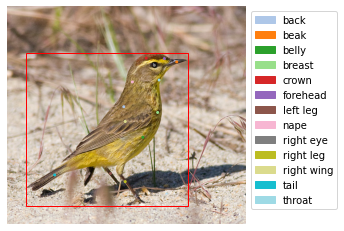

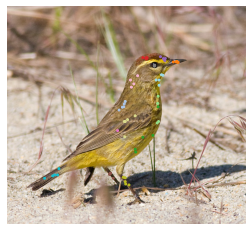

--------------- represented in dataset
image size: torch.Size([299, 299, 3])
0-indexed class id (describe bird is 1-indexed): 173


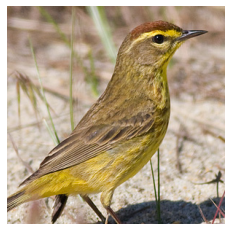

In [56]:
cub = CUB()
print('# images:', len(cub)) # should be 11788 - 8 (-8 b/c 8 gray scale images)

train_indices = [i for i in range(len(cub)) if not is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
test_indices = [i for i in range(len(cub)) if is_test_bird_idx(birdfile2idx(cub.images_path[i]))]
cub_train = CUB_train_transform(Subset(cub, train_indices))
cub_test = CUB_test_transform(Subset(cub, test_indices))

def show_cub_data(dataset, idx):
    filename = dataset[idx]['filename']
    describe_bird(filename)

    print('--------------- represented in dataset')
    im, y = dataset[idx]['x'].permute(1,2,0), dataset[idx]['y'] 
    print('image size:',  im.shape)
    plt.imshow((im - im.min()) / (im.max() - im.min()))
    print('0-indexed class id (describe bird is 1-indexed):', y)
    plt.axis('off')
    plt.show()
    
show_cub_data(cub_test, 30)

# Ground truth concepts bottleneck model

In [57]:
# accuracy
acc_criterion = lambda o, y: (o.argmax(1) == y).float()

# dataset
loader_xy = DataLoader(SubColumn(cub_train, ['attr', 'y']), batch_size=64, shuffle=True, num_workers=8)
loader_xy_te = DataLoader(SubColumn(cub_test, ['attr', 'y']), batch_size=64, shuffle=False, num_workers=8)

train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 1.0%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.092e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 4.639e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 4.219e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 3.833e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 3.479e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 3.160e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 2.872e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 2.615e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 2.388e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 2.186e+00


test eval: 100%|██████████| 91/91 [00:10<00:00,  8.48it/s]


task acc after training: 86.1%


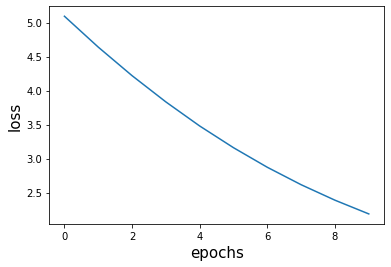

In [61]:
def ground_truth_concept_model(loader_xy, loader_xy_te, attr_names, n_epochs=10, report_every=1, plot=True, device='cuda'):
    # regular model
    net = GT_CUB_Subset_Concept_Model(attr_names)
    net.to(device)
    print('task acc before training: {:.1f}%'.format(test(net, loader_xy, acc_criterion, device=device) * 100))
    
    # train
    opt = optim.Adam(net.parameters()) # optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, device=device)
    if plot: plot_log(log)
    print('task acc after training: {:.1f}%'.format(test(net, loader_xy_te, acc_criterion, device=device) * 100))
    return net

attr_names = [
 'has_crown_color::white',
 'has_back_color::buff',
 'has_wing_color::black',
 'has_upperparts_color::yellow',
 'has_crown_color::grey',
 'has_back_color::white',
 'has_belly_pattern::solid',
 'has_breast_color::grey',
 'has_shape::perching-like',
 'has_primary_color::brown',
 'has_size::very_small_(3_-_5_in)',
 'has_leg_color::black',
 'has_forehead_color::blue',
 'has_underparts_color::buff',
 'has_belly_color::white',
 'has_back_pattern::solid',
 'has_underparts_color::black',
 'has_bill_length::about_the_same_as_head',
 'has_underparts_color::yellow',
 'has_leg_color::grey',
 'has_back_color::black',
 'has_back_pattern::multi-colored',
 'has_head_pattern::capped',
 'has_wing_color::grey',
 'has_forehead_color::red',
 'has_eye_color::black',
 'has_breast_pattern::multi-colored',
 'has_wing_pattern::multi-colored',
 'has_bill_color::grey',
 'has_back_pattern::striped'
]
gt_concept_model = ground_truth_concept_model(loader_xy, loader_xy_te, attr_names, n_epochs=10, report_every=1, device='cpu')

  0%|          | 0/30 [00:00<?, ?it/s]

(200, 108)


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 1.0%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.260e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 5.089e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 4.927e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 4.775e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 4.632e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 4.497e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 4.369e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 4.250e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 4.138e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 4.032e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 22.7%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.5%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.102e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 4.648e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 4.227e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 3.838e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 3.485e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 3.162e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 2.873e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 2.613e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 2.381e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 2.175e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 88.5%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.5%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 4.954e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 4.211e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 3.548e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 2.973e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 2.489e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 2.090e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 1.768e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 1.508e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 1.298e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 1.125e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 98.0%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.0%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 4.602e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 3.258e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 2.274e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 1.610e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 1.177e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 8.927e-01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 7.017e-01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 5.686e-01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 4.717e-01


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 3.983e-01


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 100.0%


  0%|          | 0/30 [00:00<?, ?it/s]


ValueError: The number of medoids (150) must be less than the number of samples 108.

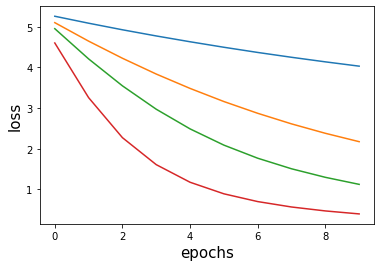

In [66]:
class_attributes = get_class_attributes()
maj_concepts = class_attributes.loc[:, ((class_attributes >= 50).sum(0) >= 10)] >= 50 # CBM paper report 112 concepts
print(maj_concepts.shape) # CBM paper (200, 112)

def get_medoids_concepts(n_clusters):
    lowest_error_ind_maj, lowest_error = None, np.inf
    for i in tqdm.trange(30):
        kmedoids = KMedoids(n_clusters=n_clusters, metric='correlation', init='k-medoids++').fit(maj_concepts.T)
        ind_maj_concepts = maj_concepts.iloc[:, kmedoids.medoid_indices_]
        abs_sum = np.array(np.abs(ind_maj_concepts.corr())).sum()
        if abs_sum < lowest_error:
            lowest_error = abs_sum
            lowest_error_ind_maj = ind_maj_concepts

    ind_maj_concepts = lowest_error_ind_maj
    return ind_maj_concepts

n_concepts = [10, 30, 50, 100, 108] # 150, 200, 250, 312]
concepts = np.array(get_class_attributes().columns)
te_accs = []
for i in range(1):
    for j in n_concepts:
        attr_names = list(get_medoids_concepts(j).columns)
        gt_concept_model = ground_truth_concept_model(loader_xy, loader_xy_te, attr_names, n_epochs=10, report_every=1, device='cpu')
        te_accs.append(test(gt_concept_model, loader_xy_te, acc_criterion, device='cpu'))

train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.0%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.307e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 5.280e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 5.256e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 5.232e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 5.210e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 5.188e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 5.168e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 5.147e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 5.129e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 5.111e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 2.3%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.0%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.233e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 5.080e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 4.935e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 4.799e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 4.671e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 4.551e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 4.437e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 4.330e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 4.229e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 4.135e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 21.6%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.5%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.173e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 4.856e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 4.560e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 4.287e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 4.034e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 3.801e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 3.587e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 3.392e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 3.215e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 3.053e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 68.5%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.0%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.031e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 4.431e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 3.890e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 3.408e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 2.989e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 2.625e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 2.316e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 2.052e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 1.829e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch   9: loss 1.637e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

task acc after training: 94.3%


test eval: 100%|██████████| 91/91 [00:07<00:00, 12.61it/s]


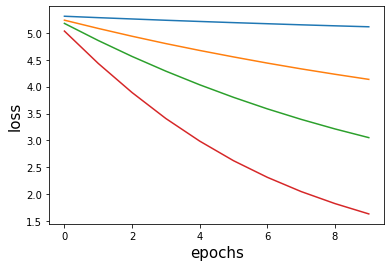

In [68]:
n_concepts = [10, 30, 50, 100] #, 150, 200, 250, 312]
concepts = np.array(get_class_attributes().columns)
random_te_accs = []
for i in range(1):
    order = np.random.permutation(len(concepts))
    for j in n_concepts:
        attr_names = concepts[order][:j]
        gt_concept_model = ground_truth_concept_model(loader_xy, loader_xy_te, attr_names, n_epochs=10, report_every=1, device='cpu')
        random_te_accs.append(test(gt_concept_model, loader_xy_te, acc_criterion, device='cpu'))

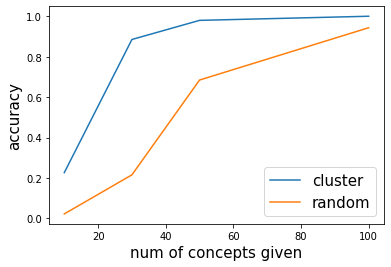

In [70]:
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('num of concepts given', fontsize=15)
plt.plot(n_concepts[:4], te_accs, label='cluster')
plt.plot(n_concepts, random_te_accs, label='random')
plt.legend(fontsize=15)

# model using learned concepts

In [124]:
class_attributes = get_class_attributes()
maj_concepts = class_attributes.loc[:, ((class_attributes >= 50).sum(0) >= 10)] >= 50 # CBM paper report 112 concepts
attrs = list(maj_concepts.columns)
cub_learned = LearnedAttrWrapper(CUB_test_transform(cub), (f'../models/attr_1_{attr}.pt' for attr in attrs))

loading learned attributes: 100%|██████████| 108/108 [00:00<00:00, 1041.32it/s]


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

input dimension: 60


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.5%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 1.758e+01, train acc 2.738e+00, test acc 2.055e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 1.079e+01, train acc 5.042e+00, test acc 4.370e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 7.911e+00, train acc 6.661e+00, test acc 5.164e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 6.304e+00, train acc 8.097e+00, test acc 5.872e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 5.294e+00, train acc 1.007e+01, test acc 7.202e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 4.749e+00, train acc 1.140e+01, test acc 8.307e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 4.528e+00, train acc 1.265e+01, test acc 8.636e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 4.379e+00, train acc 1.341e+01, test acc 9.931e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 4.276e+00, train acc 1.414e+01, test acc 9.361e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   9: loss 4.161e+00, train acc 1.521e+01, test acc 1.040e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  10: loss 4.159e+00, train acc 1.546e+01, test acc 1.036e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  11: loss 4.081e+00, train acc 1.581e+01, test acc 1.047e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  12: loss 4.016e+00, train acc 1.699e+01, test acc 1.109e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  13: loss 3.979e+00, train acc 1.696e+01, test acc 1.136e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  14: loss 3.981e+00, train acc 1.770e+01, test acc 1.119e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  15: loss 3.933e+00, train acc 1.730e+01, test acc 1.117e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  16: loss 3.916e+00, train acc 1.793e+01, test acc 1.142e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  17: loss 3.891e+00, train acc 1.811e+01, test acc 1.199e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  18: loss 3.882e+00, train acc 1.836e+01, test acc 1.142e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  19: loss 3.878e+00, train acc 1.793e+01, test acc 1.185e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  20: loss 3.810e+00, train acc 1.898e+01, test acc 1.185e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  21: loss 3.803e+00, train acc 1.873e+01, test acc 1.202e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  22: loss 3.793e+00, train acc 1.930e+01, test acc 1.135e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  23: loss 3.781e+00, train acc 1.962e+01, test acc 1.225e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  24: loss 3.718e+00, train acc 1.983e+01, test acc 1.276e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  25: loss 3.736e+00, train acc 2.002e+01, test acc 1.259e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  26: loss 3.707e+00, train acc 1.988e+01, test acc 1.268e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  27: loss 3.732e+00, train acc 2.040e+01, test acc 1.256e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  28: loss 3.713e+00, train acc 2.018e+01, test acc 1.276e+01


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch  29: loss 3.715e+00, train acc 2.032e+01, test acc 1.242e+01


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

task acc after training: 12.4%


test eval: 100%|██████████| 94/94 [00:07<00:00, 11.76it/s]


train acc after training: 20.3%


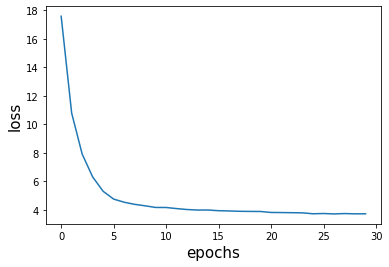

In [121]:
cub_learned_train = Subset(cub_learned, train_indices)
cub_learned_test = Subset(cub_learned, test_indices)
# dataset
loader_learned_xy = DataLoader(SubColumn(cub_learned_train, ['attrs_learned', 'y']), batch_size=64, shuffle=True, num_workers=8)
loader_learned_xy_te = DataLoader(SubColumn(cub_learned_test, ['attrs_learned', 'y']), batch_size=64, shuffle=False, num_workers=8)

def learned_concept_model(loader_xy, loader_xy_te, n_epochs=10, report_every=1, plot=True, device='cuda'):
    # regular model
    d = len(loader_xy.dataset[0][0])
    print(f'input dimension: {d}')
    net = MLP([d, 200])
    # net = nn.Sequential(LambdaNet(lambda x: torch.softmax(x.reshape((x.shape[0], -1, 2)), dim=1).reshape(x.shape)), net) # worse 9.9->3.4
    net.to(device)
    print('task acc before training: {:.1f}%'.format(test(net, loader_xy, acc_criterion, device=device) * 100))
    
    # train
    opt = optim.Adam(net.parameters())
    # opt = optim.SGD(net.parameters(), lr=0.1, momentum=0.9)
    log = train(net, loader_xy, opt, n_epochs=n_epochs, report_every=report_every, device=device, 
                report_dict={'train acc': (lambda m: test(m, loader_xy, acc_criterion, device=device) * 100, 'max'),
                            'test acc': (lambda m: test(m, loader_xy_te, acc_criterion, device=device) * 100, 'max')})
    if plot: plot_log(log)
    print('task acc after training: {:.1f}%'.format(test(net, loader_xy_te, acc_criterion, device=device) * 100))
    print('train acc after training: {:.1f}%'.format(test(net, loader_xy, acc_criterion, device=device) * 100))

    return net

learned_model = learned_concept_model(loader_learned_xy, loader_learned_xy_te, n_epochs=30, report_every=1, device='cpu')

In [ ]:
n_concepts = [10, 30, 50, 100, 108] # 150, 200, 250, 312]
te_accs_learned = []
for i in range(1):
    for j in n_concepts:
        attr_names = list(get_medoids_concepts(j).columns)
        cub_learned = LearnedAttrWrapper(CUB_test_transform(cub), (f'../models/attr_1_{attr}.pt' for attr in attr_names))
        
        cub_learned_train = Subset(cub_learned, train_indices)
        cub_learned_test = Subset(cub_learned, test_indices)
        # dataset
        loader_learned_xy = DataLoader(SubColumn(cub_learned_train, ['attrs_learned', 'y']), batch_size=64, shuffle=True, num_workers=8)
        loader_learned_xy_te = DataLoader(SubColumn(cub_learned_test, ['attrs_learned', 'y']), batch_size=64, shuffle=False, num_workers=8)
        
        learned_model = learned_concept_model(loader_learned_xy, loader_learned_xy_te, n_epochs=30, report_every=1, device='cpu')        
        te_accs_learned.append(test(learned_model, loader_learned_xy_te, acc_criterion, device='cpu'))

test eval:   0%|          | 0/94 [00:00<?, ?it/s]

input dimension: 20


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.8%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 5.818e+00, train acc 1.252e+00, test acc 1.105e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 5.364e+00, train acc 2.521e+00, test acc 2.401e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 5.120e+00, train acc 3.623e+00, test acc 3.610e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 4.947e+00, train acc 4.808e+00, test acc 4.491e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 4.815e+00, train acc 5.726e+00, test acc 4.905e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 4.709e+00, train acc 6.110e+00, test acc 5.803e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 4.624e+00, train acc 6.861e+00, test acc 6.114e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 4.552e+00, train acc 7.780e+00, test acc 6.753e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 4.491e+00, train acc 8.364e+00, test acc 7.444e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   9: loss 4.439e+00, train acc 8.564e+00, test acc 7.565e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  10: loss 4.396e+00, train acc 8.798e+00, test acc 7.737e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  11: loss 4.355e+00, train acc 9.182e+00, test acc 8.290e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  12: loss 4.322e+00, train acc 9.783e+00, test acc 8.273e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  13: loss 4.289e+00, train acc 1.005e+01, test acc 8.307e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  14: loss 4.262e+00, train acc 1.002e+01, test acc 8.618e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  15: loss 4.237e+00, train acc 1.028e+01, test acc 8.808e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  16: loss 4.214e+00, train acc 1.020e+01, test acc 8.670e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  17: loss 4.191e+00, train acc 1.047e+01, test acc 8.998e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  18: loss 4.174e+00, train acc 1.063e+01, test acc 9.309e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  19: loss 4.154e+00, train acc 1.063e+01, test acc 9.016e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  20: loss 4.140e+00, train acc 1.060e+01, test acc 9.344e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  21: loss 4.123e+00, train acc 1.085e+01, test acc 9.240e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  22: loss 4.109e+00, train acc 1.090e+01, test acc 9.085e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  23: loss 4.093e+00, train acc 1.125e+01, test acc 9.188e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  24: loss 4.083e+00, train acc 1.137e+01, test acc 9.482e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  25: loss 4.071e+00, train acc 1.149e+01, test acc 9.344e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  26: loss 4.061e+00, train acc 1.125e+01, test acc 9.551e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  27: loss 4.050e+00, train acc 1.142e+01, test acc 9.344e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  28: loss 4.039e+00, train acc 1.174e+01, test acc 9.534e+00


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch  29: loss 4.029e+00, train acc 1.174e+01, test acc 9.585e+00


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

task acc after training: 9.6%


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

train acc after training: 11.7%


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

input dimension: 60


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.7%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 1.870e+01, train acc 2.638e+00, test acc 2.487e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 1.125e+01, train acc 4.808e+00, test acc 4.093e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 7.739e+00, train acc 7.846e+00, test acc 6.701e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 6.188e+00, train acc 1.055e+01, test acc 8.290e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 5.414e+00, train acc 1.192e+01, test acc 1.009e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 4.814e+00, train acc 1.411e+01, test acc 1.067e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 4.501e+00, train acc 1.564e+01, test acc 1.161e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 4.332e+00, train acc 1.674e+01, test acc 1.226e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 4.165e+00, train acc 1.766e+01, test acc 1.290e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   9: loss 4.088e+00, train acc 1.876e+01, test acc 1.333e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  10: loss 3.993e+00, train acc 1.888e+01, test acc 1.366e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  11: loss 3.948e+00, train acc 1.875e+01, test acc 1.359e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  12: loss 3.926e+00, train acc 2.048e+01, test acc 1.478e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  13: loss 3.830e+00, train acc 2.088e+01, test acc 1.485e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  14: loss 3.880e+00, train acc 2.043e+01, test acc 1.442e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  15: loss 3.791e+00, train acc 2.132e+01, test acc 1.494e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  16: loss 3.762e+00, train acc 2.144e+01, test acc 1.430e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  17: loss 3.724e+00, train acc 2.184e+01, test acc 1.532e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  18: loss 3.678e+00, train acc 2.259e+01, test acc 1.585e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  19: loss 3.652e+00, train acc 2.249e+01, test acc 1.592e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  20: loss 3.665e+00, train acc 2.332e+01, test acc 1.627e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  21: loss 3.664e+00, train acc 2.304e+01, test acc 1.587e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  22: loss 3.599e+00, train acc 2.424e+01, test acc 1.646e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  23: loss 3.582e+00, train acc 2.434e+01, test acc 1.649e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  24: loss 3.554e+00, train acc 2.414e+01, test acc 1.660e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  25: loss 3.544e+00, train acc 2.444e+01, test acc 1.691e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  26: loss 3.496e+00, train acc 2.444e+01, test acc 1.663e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  27: loss 3.547e+00, train acc 2.471e+01, test acc 1.725e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  28: loss 3.517e+00, train acc 2.412e+01, test acc 1.649e+01


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch  29: loss 3.503e+00, train acc 2.541e+01, test acc 1.661e+01


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

task acc after training: 16.6%


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

train acc after training: 25.4%


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

input dimension: 100


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.4%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 2.222e+01, train acc 2.771e+00, test acc 2.297e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 9.891e+00, train acc 5.743e+00, test acc 4.145e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 6.672e+00, train acc 9.115e+00, test acc 7.185e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 5.315e+00, train acc 1.250e+01, test acc 9.499e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 4.651e+00, train acc 1.523e+01, test acc 1.098e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 4.261e+00, train acc 1.818e+01, test acc 1.218e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 4.060e+00, train acc 1.912e+01, test acc 1.314e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 3.917e+00, train acc 2.088e+01, test acc 1.413e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 3.783e+00, train acc 2.120e+01, test acc 1.409e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   9: loss 3.716e+00, train acc 2.200e+01, test acc 1.520e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  10: loss 3.689e+00, train acc 2.424e+01, test acc 1.534e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  11: loss 3.549e+00, train acc 2.366e+01, test acc 1.547e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  12: loss 3.543e+00, train acc 2.469e+01, test acc 1.646e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  13: loss 3.438e+00, train acc 2.596e+01, test acc 1.655e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  14: loss 3.420e+00, train acc 2.720e+01, test acc 1.743e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  15: loss 3.389e+00, train acc 2.781e+01, test acc 1.698e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  16: loss 3.399e+00, train acc 2.910e+01, test acc 1.772e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  17: loss 3.347e+00, train acc 2.845e+01, test acc 1.774e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  18: loss 3.275e+00, train acc 2.866e+01, test acc 1.746e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  19: loss 3.314e+00, train acc 3.033e+01, test acc 1.869e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  20: loss 3.222e+00, train acc 2.983e+01, test acc 1.841e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  21: loss 3.225e+00, train acc 3.095e+01, test acc 1.886e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  22: loss 3.145e+00, train acc 3.003e+01, test acc 1.858e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  23: loss 3.141e+00, train acc 3.073e+01, test acc 1.898e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  24: loss 3.159e+00, train acc 3.135e+01, test acc 1.845e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  25: loss 3.126e+00, train acc 3.235e+01, test acc 1.955e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  26: loss 3.138e+00, train acc 3.119e+01, test acc 1.867e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  27: loss 3.143e+00, train acc 3.344e+01, test acc 1.983e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  28: loss 3.075e+00, train acc 3.306e+01, test acc 2.003e+01


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

epoch  29: loss 3.073e+00, train acc 3.386e+01, test acc 2.043e+01


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

task acc after training: 20.4%


test eval:   0%|          | 0/91 [00:00<?, ?it/s]

train acc after training: 33.9%


test eval:   0%|          | 0/94 [00:00<?, ?it/s]

input dimension: 200


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

task acc before training: 0.6%


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   0: loss 1.642e+01, train acc 4.508e+00, test acc 3.696e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   1: loss 7.398e+00, train acc 1.179e+01, test acc 7.858e+00


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   2: loss 5.150e+00, train acc 1.740e+01, test acc 1.100e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   3: loss 4.371e+00, train acc 2.140e+01, test acc 1.339e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   4: loss 3.911e+00, train acc 2.387e+01, test acc 1.409e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   5: loss 3.711e+00, train acc 2.788e+01, test acc 1.746e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   6: loss 3.494e+00, train acc 3.025e+01, test acc 1.701e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   7: loss 3.333e+00, train acc 3.182e+01, test acc 1.850e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   8: loss 3.261e+00, train acc 3.336e+01, test acc 1.936e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch   9: loss 3.161e+00, train acc 3.651e+01, test acc 2.086e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  10: loss 2.994e+00, train acc 3.626e+01, test acc 2.016e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  11: loss 2.994e+00, train acc 3.761e+01, test acc 2.143e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  12: loss 2.926e+00, train acc 3.725e+01, test acc 2.067e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  13: loss 2.864e+00, train acc 3.982e+01, test acc 2.136e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  14: loss 2.785e+00, train acc 4.030e+01, test acc 2.211e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  15: loss 2.732e+00, train acc 4.249e+01, test acc 2.302e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  16: loss 2.719e+00, train acc 4.234e+01, test acc 2.295e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  17: loss 2.667e+00, train acc 4.331e+01, test acc 2.294e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  18: loss 2.634e+00, train acc 4.521e+01, test acc 2.485e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  19: loss 2.562e+00, train acc 4.497e+01, test acc 2.392e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  20: loss 2.529e+00, train acc 4.514e+01, test acc 2.383e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  21: loss 2.499e+00, train acc 4.489e+01, test acc 2.359e+01


train step for 1 epoch:   0%|          | 0/94 [00:00<?, ?it/s]

epoch  22: loss 2.472e+00, train acc 4.720e+01, test acc 2.468e+01


test eval:  73%|███████▎  | 66/91 [00:04<00:01, 16.41it/s]

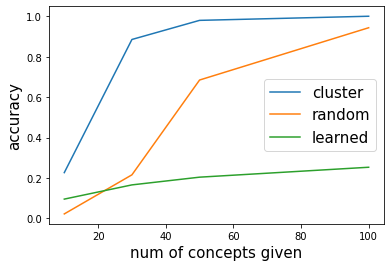

In [130]:
plt.ylabel('accuracy', fontsize=15)
plt.xlabel('num of concepts given', fontsize=15)
plt.plot(n_concepts[:4], te_accs, label='cluster')
plt.plot(n_concepts[:4], random_te_accs[:4], label='random')
plt.plot(n_concepts[:4], te_accs_learned[:4], label='learned')

plt.legend(fontsize=15)

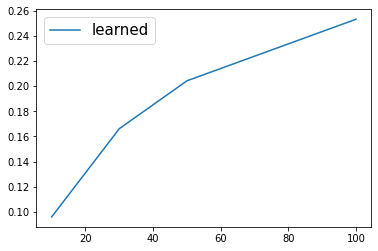

In [131]:
plt.plot(n_concepts[:4], te_accs_learned[:4], label='learned')

plt.legend(fontsize=15)